### Poisson equation with Dirichlet boundary conditions

In [1]:
# Importing libraries
from neurodiffeq.solvers import Solver2D
from neurodiffeq import diff
from neurodiffeq.conditions import DirichletBVP2D
from neurodiffeq.networks import FCNN
from neurodiffeq.generators import Generator2D

from torch.optim import Adam
from torch.nn import MSELoss, Tanh

import matplotlib.pyplot as plt

In [ ]:
# L(u) + 1 = 0
poisson_pde = lambda u, x, y: [diff(u, x, order = 2) + diff(u, y, order = 2) + 1]

In [3]:
# Dirichlet boundary conditions
clamped_condition = DirichletBVP2D(
    x_min = 0,
    x_min_val = lambda y: 0,
    x_max = 1,
    x_max_val = lambda y: 0,
    y_min = 0,
    y_min_val = lambda x: 0,
    y_max = 1,
    y_max_val = lambda x: 0
    )

In [4]:
# Generators of train/test points
n = 30
m = 15

train_gen = Generator2D(
    grid = (n, n),
    xy_min = (0, 0),
    xy_max = (1, 1),
    method = 'equally-spaced'
    )

test_gen = Generator2D(
    grid = (m, m),
    xy_min = (0, 0),
    xy_max = (1, 1),
    method = 'equally-spaced'
    )

In [5]:
# Creating the NN
network = FCNN(
    n_input_units = 2,
    n_output_units = 1,
    hidden_units = (32, 32, 32),
    actv = Tanh
)

In [6]:
# Adam optimizer
optimizer = Adam(network.parameters(), lr = 1e-03)

In [7]:
# Loss function: MSE
loss_function = MSELoss()

In [8]:
# solver2D object
solver2D = Solver2D(
    pde_system = poisson_pde,
    conditions = [clamped_condition],
    xy_min = (0, 0),
    xy_max = (1, 1),
    nets = [network],
    train_generator = train_gen,
    valid_generator = test_gen,
    optimizer = optimizer,
    loss_fn = loss_function
    )

In [9]:
# Training the NN
solver2D.fit(max_epochs = 2_000)

Training Progress:   0%|          | 0/2000 [00:00<?, ?it/s]

In [10]:
# Info
solver2D.get_internals()

{'metrics': {},
 'n_batches': {'train': 1, 'valid': 4},
 'best_nets': [FCNN(
    (NN): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32, bias=True)
      (5): Tanh()
      (6): Linear(in_features=32, out_features=1, bias=True)
    )
  )],
 'criterion': <function neurodiffeq.solvers.BaseSolver._set_loss_fn.<locals>.<lambda>(r, f, x)>,
 'loss_fn': <function neurodiffeq.solvers.BaseSolver._set_loss_fn.<locals>.<lambda>(r, f, x)>,
 'conditions': [<neurodiffeq.conditions.DirichletBVP2D at 0x1bc33d4ba10>],
 'global_epoch': 2000,
 'lowest_loss': 0.018209521529432504,
 'n_funcs': 1,
 'nets': [FCNN(
    (NN): Sequential(
      (0): Linear(in_features=2, out_features=32, bias=True)
      (1): Tanh()
      (2): Linear(in_features=32, out_features=32, bias=True)
      (3): Tanh()
      (4): Linear(in_features=32, out_features=32

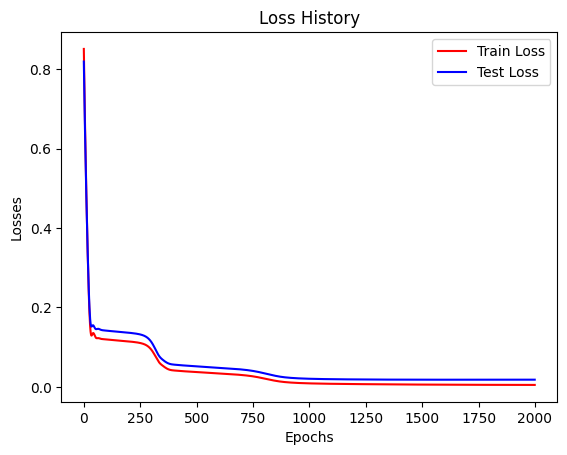

In [11]:
# Plotting the loss history
train_loss, test_loss = (solver2D.metrics_history['train_loss'], solver2D.metrics_history['valid_loss'])

plt.plot(train_loss, label = "Train Loss", color = "red")
plt.plot(test_loss, label = "Test Loss", color = "blue")
plt.title("Loss History")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.show()

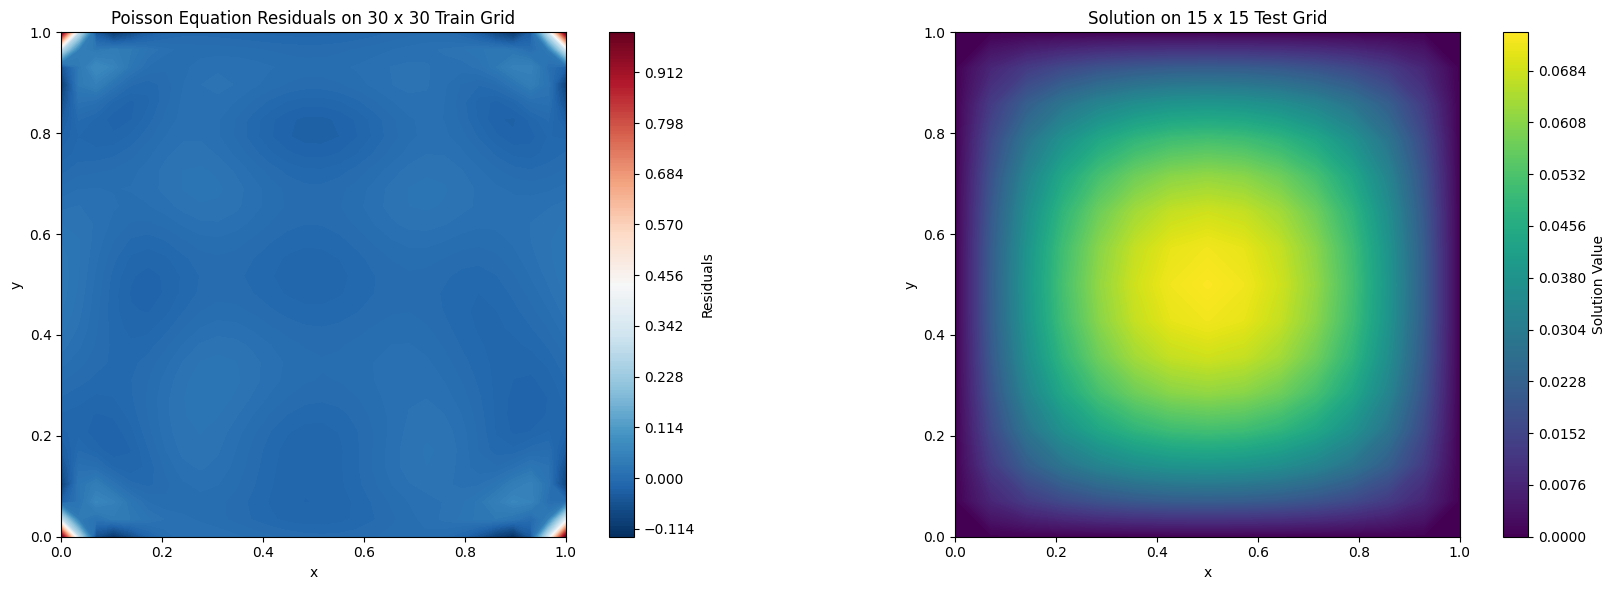

In [12]:
# Plotting the residuals and the solution
x_train, y_train = train_gen.get_examples()
x_train = x_train.detach().numpy()
y_train = y_train.detach().numpy()

train_res = solver2D.get_residuals(x_train, y_train, to_numpy = True)

x_train = x_train.reshape(n, n)
y_train = y_train.reshape(n, n)
train_res = train_res.reshape(n, n)

solution_func = solver2D.get_solution()
test_points = test_gen.get_examples()
solution_on_test_points = solution_func(*test_points)

x_test = test_points[0].detach().numpy().reshape(m, m)
y_test = test_points[1].detach().numpy().reshape(m, m)
solution_on_test_points = solution_on_test_points.detach().numpy().reshape(m, m)

fig, axes = plt.subplots(1, 2, figsize = (18, 6))

# First subplot: Residuals on train grid
contour1 = axes[0].contourf(x_train, y_train, train_res, levels = 200, cmap = 'RdBu_r')
fig.colorbar(contour1, ax = axes[0], label = 'Residuals')
axes[0].set_title(f'Poisson Equation Residuals on {n} x {n} Train Grid')
axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_aspect('equal')

# Second subplot: Solution on test grid
contour2 = axes[1].contourf(x_test, y_test, solution_on_test_points, levels = 200, cmap = 'viridis')
fig.colorbar(contour2, ax = axes[1], label = 'Solution Value')
axes[1].set_title(f'Solution on {m} x {m} Test Grid')
axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_aspect('equal')

plt.tight_layout()
plt.show()